# 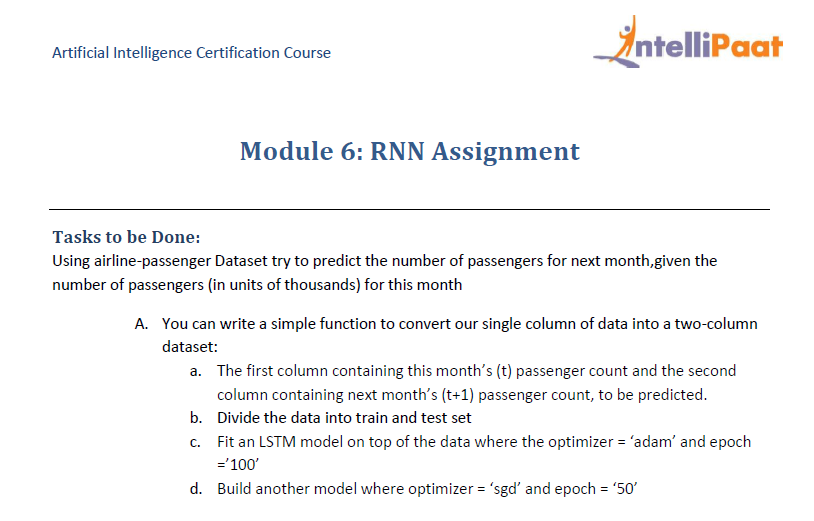

# Tasks to be Done:
### Using airline-passenger Dataset try to predict the number of passengers for next month,given the number of passengers (in units of thousands) for this month
###    A. You can write a simple function to convert our single column of data into a two-column dataset:
        a. The first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.
        b. Divide the data into train and test set
        c. Fit an LSTM model on top of the data where the optimizer = ‘adam’ and epoch =’100’
        d. Build another model where optimizer = ‘sgd’ and epoch = ‘50’

### 1. Importing required Library

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from sklearn.model_selection import train_test_split
import tensorflow as tf
import csv

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

### 2. Reading the CSV file

In [2]:
df = pd.read_csv('airline-passengers.csv')
# too see max columns
pd.set_option('display.max_columns',None)
# print dataframe
df.head()

,"""Month"",""Passengers"""
0,"""1949-01"",112"
1,"""1949-02"",118"
2,"""1949-03"",132"
3,"""1949-04"",129"
4,"""1949-05"",121"


### 3. Exploratory Data Analysis

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 1 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   "Month","Passengers"  144 non-null    object
dtypes: object(1)
memory usage: 1.3+ KB


### A. You can write a simple function to convert our single column of data into a two-column dataset:

#### 1.A.1. Created a function splitColumn to split column single column of data into a two column

In [4]:
def splitColumn(data, columnname, separatedby):
    col_list=columnname.replace('\"', '').split(separatedby)
    data[col_list] = data[columnname].apply(lambda x: pd.Series(str(x).split(separatedby)))
    data = data.drop(columns=columnname, axis=0)
    data = data.apply(lambda s:s.str.replace('"', ""))
    return data

In [5]:
df = splitColumn(df,'"Month","Passengers"',',')

In [6]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    object
dtypes: object(2)
memory usage: 2.4+ KB


#### 1.A.2. Converted Passengers column from object to int

In [8]:
df['Passengers']= df['Passengers'].astype(str).astype(int)

In [9]:
df.head()

,Month,Passengers
0,1949-01,112
1,1949-02,118
2,1949-03,132
3,1949-04,129
4,1949-05,121


In [10]:
df.tail()

,Month,Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Month       144 non-null    object
 1   Passengers  144 non-null    int32 
dtypes: int32(1), object(1)
memory usage: 1.8+ KB


#### 1.A. a. The first column containing this month’s (t) passenger count and the second column containing next month’s (t+1) passenger count, to be predicted.

#### 1.A.a.1 Added new column Next_Passengers that is required to be predicted. Last record of the new column is Nan and replacing it with median() of Passengers column

In [12]:
df["Next_Passengers"] = df['Passengers'].shift(-1)

In [13]:
df.tail()

,Month,Passengers,Next_Passengers
139,1960-08,606,508.0
140,1960-09,508,461.0
141,1960-10,461,390.0
142,1960-11,390,432.0
143,1960-12,432,NaN


In [14]:
df['Next_Passengers'] = df['Next_Passengers'].replace(to_replace=[None], value=np.nan)

In [15]:
df['Next_Passengers'] = df['Next_Passengers'].fillna(df['Passengers'].median())

In [16]:
df.tail()

,Month,Passengers,Next_Passengers
139,1960-08,606,508.0
140,1960-09,508,461.0
141,1960-10,461,390.0
142,1960-11,390,432.0
143,1960-12,432,265.5


#### 1.A.a.2 By default the datatype of the new column Next_Passengers is Float now converting it into int.

In [17]:
df['Next_Passengers']= df['Next_Passengers'].astype(int)

In [18]:
df.tail()

,Month,Passengers,Next_Passengers
139,1960-08,606,508
140,1960-09,508,461
141,1960-10,461,390
142,1960-11,390,432
143,1960-12,432,265


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 144 entries, 0 to 143
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Month            144 non-null    object
 1   Passengers       144 non-null    int32 
 2   Next_Passengers  144 non-null    int32 
dtypes: int32(2), object(1)
memory usage: 2.4+ KB


#### 1.A.a.3 It is reshaping the Passengers and Next_Passengers columns and assigning them to the numpy arrays data and pred_data respectively. 

In [20]:
data = df['Passengers']
data = np.array(data).reshape(-1,1)


In [21]:
pred_data =df["Next_Passengers"]
pred_data =np.array(pred_data).reshape(-1,1)

#### 1.A.a.4 Scaling both numpy arrays data and pred_data using the standard method.

In [22]:
scaler= MinMaxScaler()
data=scaler.fit_transform(data)
pred_data =scaler.fit_transform(pred_data)

In [23]:
type(data)

numpy.ndarray

#### 1.A.a.5 Ploting both data and pred_data separately 

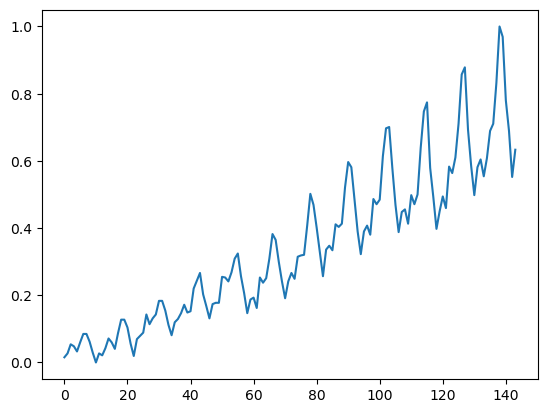

In [24]:
plt.plot(data)

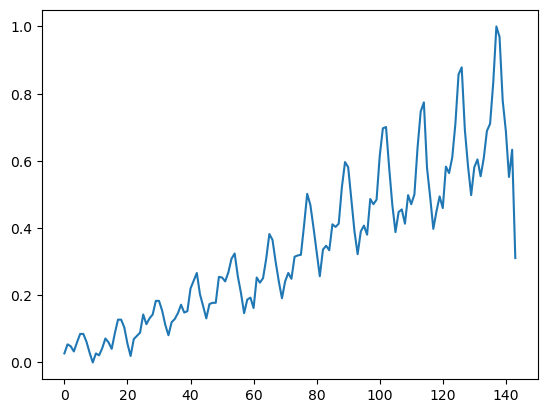

In [25]:
plt.plot(pred_data)

## A. b. Divide the data into train and test set

#### 1.A.a.6 Splitting data and pred_data for training and testing.

In [26]:
train_size=100
test_size=44

In [27]:
train=data[0:train_size,:]
test=data[train_size:,:]

In [28]:
train.shape

(100, 1)

In [29]:
test.shape

(44, 1)

In [30]:
P_train=pred_data[0:train_size,:]
p_test=pred_data[train_size:,:]

In [31]:
P_train.shape

(100, 1)

In [32]:
p_test.shape

(44, 1)

#### 1.A.a.7 Reshaping train and test data for both training and testing.

In [33]:
X_train = train.reshape(train.shape[0], train.shape[1], 1)
X_test = test.reshape(test.shape[0], test.shape[1], 1)

In [34]:
X_train.shape # , 

(100, 1, 1)

In [35]:
X_test.shape

(44, 1, 1)

In [36]:
Y_train = P_train.reshape(P_train.shape[0], P_train.shape[1], 1)
Y_test = p_test.reshape(p_test.shape[0], p_test.shape[1], 1)

In [37]:
type(Y_test)

numpy.ndarray

## A. c. Fit an LSTM model on top of the data where the optimizer = ‘adam’ and epoch =’100’

#### 1.A.c.1 Creating model to fit the data.

In [38]:
model = Sequential()
model.add(LSTM(5, input_shape = (1, 1)))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [39]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 5)                 140       
                                                                 
 dense (Dense)               (None, 1)                 6         
                                                                 
Total params: 146 (584.00 Byte)
Trainable params: 146 (584.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [40]:
model.fit(X_train, Y_train, epochs=100, batch_size=1)

Epoch 1/100
100/100 [==============================] - 3s 3ms/step - loss: 0.0522
Epoch 2/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0266
Epoch 3/100
100/100 [==============================] - 0s 4ms/step - loss: 0.0194
Epoch 4/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0178
Epoch 5/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0167
Epoch 6/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0156
Epoch 7/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0145
Epoch 8/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0136
Epoch 9/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0124
Epoch 10/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0114
Epoch 11/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0104
Epoch 12/100
100/100 [==============================] - 0s 3ms/step - loss: 0.0093
Epoch 13/100


100/100 [==============================] - 0s 2ms/step - loss: 0.0022
Epoch 100/100
100/100 [==============================] - 0s 2ms/step - loss: 0.0022


In [41]:
y_pred = model.predict(X_test)

2/2 [==============================] - 1s 3ms/step


In [42]:
# scaler.scale_

In [43]:
y_pred = scaler.inverse_transform(y_pred)

In [44]:
y_test = Y_test.reshape(-1, 1)
y_test = scaler.inverse_transform(y_test)

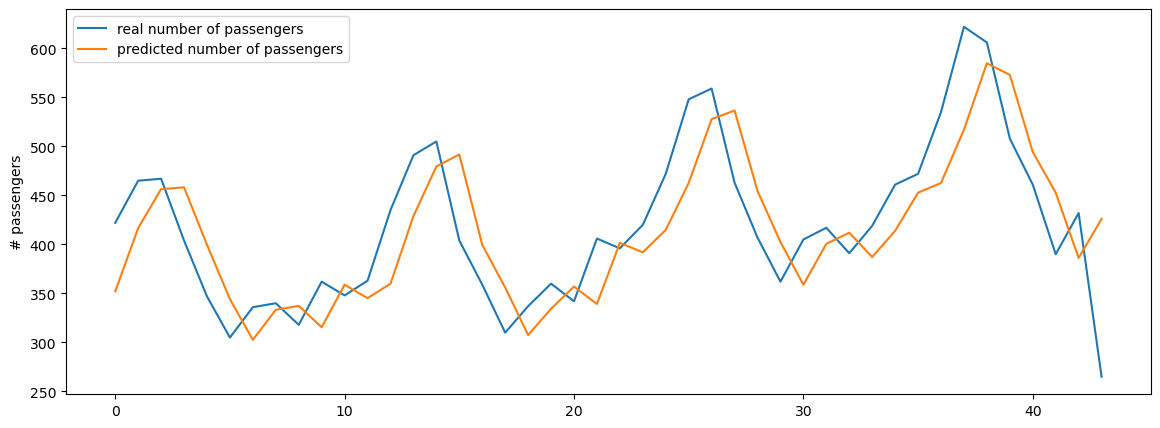

In [45]:
plt.figure(figsize=(14,5))
plt.plot(y_test, label = 'real number of passengers')
plt.plot(y_pred, label = 'predicted number of passengers')
plt.ylabel('# passengers')
plt.legend()
plt.show()

## A. d. Build another model where optimizer = ‘sgd’ and epoch = ‘50’

In [46]:
# del model2

In [47]:
model2 = Sequential()
model2.add(LSTM(5, input_shape = (1, 1)))
model2.add(Dense(1))
# model2.compile(loss = 'mean_squared_error', optimizer = 'sgd')
model2.compile(loss='mean_squared_error', #tf.keras.losses.categorical_crossentropy,
          optimizer=tf.keras.optimizers.SGD(), #learning_rate=0.1
          metrics=["acc"])

In [48]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 5)                 140       
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 146 (584.00 Byte)
Trainable params: 146 (584.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [49]:
model2.fit(X_train, Y_train, epochs=50, batch_size=1)

Epoch 1/50
100/100 [==============================] - 2s 2ms/step - loss: 0.0369 - acc: 0.0100
Epoch 2/50
100/100 [==============================] - 0s 2ms/step - loss: 0.0232 - acc: 0.0100
Epoch 3/50
100/100 [==============================] - 0s 2ms/step - loss: 0.0230 - acc: 0.0100
Epoch 4/50
100/100 [==============================] - 0s 2ms/step - loss: 0.0226 - acc: 0.0100
Epoch 5/50
100/100 [==============================] - 0s 2ms/step - loss: 0.0222 - acc: 0.0100
Epoch 6/50
100/100 [==============================] - 0s 2ms/step - loss: 0.0218 - acc: 0.0100
Epoch 7/50
100/100 [==============================] - 0s 2ms/step - loss: 0.0216 - acc: 0.0100
Epoch 8/50
100/100 [==============================] - 0s 2ms/step - loss: 0.0211 - acc: 0.0100
Epoch 9/50
100/100 [==============================] - 0s 2ms/step - loss: 0.0209 - acc: 0.0100
Epoch 10/50
100/100 [==============================] - 0s 2ms/step - loss: 0.0205 - acc: 0.0100
Epoch 11/50
100/100 [============================

In [50]:
y_pred2 = model2.predict(X_test)

2/2 [==============================] - 1s 5ms/step


In [51]:
# scaler.scale_

In [52]:
y_pred2 = scaler.inverse_transform(y_pred2)

In [53]:
y_test2 = Y_test.reshape(-1, 1)
y_test2 = scaler.inverse_transform(y_test2)

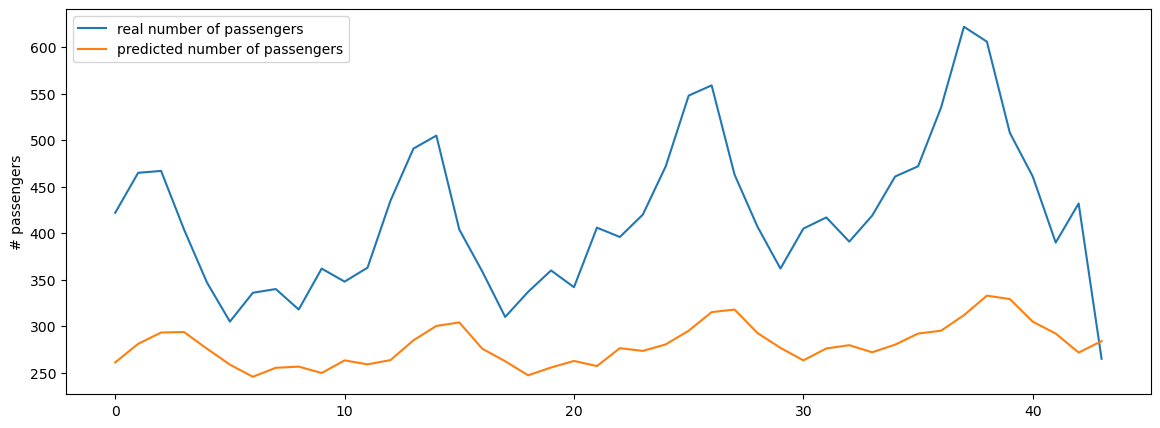

In [54]:
plt.figure(figsize=(14,5))
plt.plot(y_test2, label = 'real number of passengers')
plt.plot(y_pred2, label = 'predicted number of passengers')
plt.ylabel('# passengers')
plt.legend()
plt.show()